### Context 
We investigate a given topic on DBPEDIA.FR (the elections in 2012) from a time series analysis perspective.

### Methodology
* retrieve dbpedia history from sparql endpoint
* clean the data
* get the time series associated to the revision history of the pages
* time series analysis
* modelling

In [162]:
from SPARQLWrapper import SPARQLWrapper, JSON
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

sparql = SPARQLWrapper("http://dbpedia-historique.inria.fr/sparql")
a = "Élection_présidentielle_française_de_2012"

### Query 1: get all the people involved in the topic
The query returns the list of the linked pages of people in the main page of the topic, associated with the monthly revision history for the year 2012.

In [163]:
query = """prefix db:   <http://fr.dbpedia.org/resource/>
prefix dbo:  <http://dbpedia.org/ontology/>
prefix dbfr: <http://ns.inria.fr/dbpediafr/voc#>
prefix foaf: <http://xmlns.com/foaf/0.1/>
prefix dc:   <http://purl.org/dc/element/1.1/>

select  * where {

        {select distinct * where {
            db:Élection_présidentielle_française_de_2012 dbo:wikiPageWikiLink/(dbo:wikiPageRedirects)? ?res .
            ?res a foaf:Person
        }}
   
   
            ?rev dc:date ?date .
            filter contains(str(?date), "2012")
            ?x dbfr:revPerMonth ?rev .
            ?x foaf:primaryTopic ?res .
            ?rev rdf:value ?c .
       
   
}"""

In [164]:
sparql.setQuery(query)

sparql.setReturnFormat(JSON)
results = sparql.query().convert()

In [165]:
from collections import defaultdict
tmp = defaultdict(set)
for record in results["results"]["bindings"]:
    date = pd.to_datetime(record['date']['value'], format="%m/%Y")
    node_id = record['rev']['value']
    uri = record['res']['value']
    num_rev = int(record['c']['value'])
    tmp[uri].add((date, num_rev))  # avoid duplicates

dic = defaultdict(list, ((k, list(v)) for k, v in tmp.items()))

In [166]:
dfs = []
uris = []
for uri, values in dic.items():
    uris.append(uri)
    k = uri.split("/")[-1:][0]
    d = sorted(values, key=lambda x: x[0])
    df = pd.DataFrame.from_records(d, columns=['dateval', k])
    df.index = pd.DatetimeIndex(df.dateval)
    del df['dateval']
    dfs.append(df)
    # print(uri)
    
yearly_series = pd.concat(dfs, axis=1).fillna(0)

In [167]:
yearly_series.head()

,Mustapha_Ben_Jaafar,Yves_Calvi,Antoni_Martí,Eva_Joly,Alain_Duhamel,Nicolas_Dupont-Aignan,Florian_Philippot,Alain_Juppé,David_Pujadas,Pedro_Passos_Coelho,...,Christophe_Barbier,Jean_Charest,Olivier_Besancenot,Barack_Obama,Franz-Olivier_Giesbert,Pierre_Carles,Nicolas_Miguet,Alain_Marschall,Jean-Michel_Aphatie,Jacques_Cheminade
2012-01-01,10.0,2.0,0.0,63,4.0,4,19.0,9.0,0.0,5.0,...,39,8.0,8.0,6,3.0,0.0,21.0,1.0,1.0,10.0
2012-02-01,6.0,2.0,3.0,37,2.0,27,0.0,18.0,23.0,1.0,...,7,0.0,4.0,10,6.0,22.0,24.0,0.0,0.0,205.0
2012-03-01,1.0,4.0,1.0,23,11.0,33,0.0,3.0,13.0,7.0,...,25,5.0,5.0,9,11.0,3.0,24.0,0.0,19.0,273.0
2012-04-01,0.0,0.0,1.0,61,4.0,61,0.0,6.0,17.0,0.0,...,5,6.0,7.0,12,52.0,27.0,1.0,1.0,15.0,101.0
2012-05-01,0.0,4.0,2.0,46,5.0,22,0.0,47.0,24.0,1.0,...,8,24.0,0.0,4,7.0,18.0,2.0,1.0,4.0,20.0


* 69 people
* Distribution of number of reviews in year 2012 (monthly granularity).

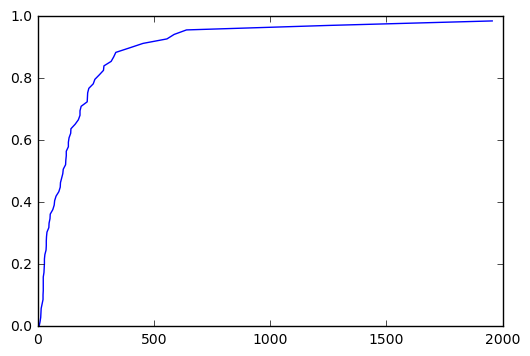

In [194]:
y = sorted(yearly_series.sum())
cdf = np.array([(i/len(y),x) for i, x in enumerate(y)])
Y = [x[0] for x in cdf]
X = [x[1] for x in cdf]
plt.plot(X,Y)

In [200]:
criteria = yearly_series.sum(axis=0) > 200
df = yearly_series[criteria.index[criteria]]
df.head()

,Eva_Joly,Nicolas_Dupont-Aignan,Ségolène_Royal,Arnaud_Montebourg,Marine_Le_Pen,Angela_Merkel,Philippe_Pétain,Jean-Marc_Ayrault,François_Hollande,François_Bayrou,Mario_Monti,Laurence_Ferrari,Dominique_Strauss-Kahn,Nicolas_Sarkozy,Jean-Luc_Mélenchon,Nathalie_Kosciusko-Morizet,Manuel_Valls,Barack_Obama,Jacques_Cheminade
2012-01-01,63,4,17,5,64.0,16,35,5,73,41,7.0,5,6,73,47,4,10,6,10.0
2012-02-01,37,27,17,6,26.0,6,5,15,72,57,11.0,20,12,62,29,54,11,10,205.0
2012-03-01,23,33,21,3,26.0,17,7,1,66,28,9.0,5,33,135,62,16,7,9,273.0
2012-04-01,61,61,12,4,86.0,23,17,31,204,51,12.0,15,15,207,145,25,10,12,101.0
2012-05-01,46,22,37,79,39.0,24,34,316,1049,56,4.0,62,42,309,110,47,158,4,20.0


In [211]:
for name in df:
    print(name, df[name].sum())

Eva_Joly 327
Nicolas_Dupont-Aignan 215
Ségolène_Royal 283
Arnaud_Montebourg 246
Marine_Le_Pen 395.0
Angela_Merkel 265
Philippe_Pétain 336
Jean-Marc_Ayrault 587
François_Hollande 1955
François_Bayrou 285
Mario_Monti 220.0
Laurence_Ferrari 213
Dominique_Strauss-Kahn 316
Nicolas_Sarkozy 1251
Jean-Luc_Mélenchon 556
Nathalie_Kosciusko-Morizet 239
Manuel_Valls 453
Barack_Obama 214
Jacques_Cheminade 640.0


In [212]:
query2_stub = """prefix db:   <http://fr.dbpedia.org/resource/>
prefix dbo:  <http://dbpedia.org/ontology/>
prefix foaf: <http://xmlns.com/foaf/0.1/>
prefix dc:   <http://purl.org/dc/element/1.1/>
prefix voc:  <http://ns.inria.fr/dbpediafr/voc#>
prefix prov: <http://www.w3.org/ns/prov#>
select  ?res (year(?date) as ?y) (month(?date) as ?m) (day(?date) as ?d) (count(*) as ?n) (group_concat(?value ; separator=" -- ") as ?gc)
where {
    ?x foaf:primaryTopic ?res .
    ?x prov:wasRevisionOf+ ?prev .
    ?prev dc:created ?date .
    filter (year(?date) = 2012)
    ?prev rdf:note ?value
}
group by ?res year(?date) month(?date) day(?date)
order by ?m ?d
values ?res {
"""

for name in df:
    q = query2_stub + " <{}>".format(name) + "}"
    break

In [213]:
q

'prefix db:   <http://fr.dbpedia.org/resource/>\nprefix dbo:  <http://dbpedia.org/ontology/>\nprefix foaf: <http://xmlns.com/foaf/0.1/>\nprefix dc:   <http://purl.org/dc/element/1.1/>\nprefix voc:  <http://ns.inria.fr/dbpediafr/voc#>\nprefix prov: <http://www.w3.org/ns/prov#>\nselect  ?res (year(?date) as ?y) (month(?date) as ?m) (day(?date) as ?d) (count(*) as ?n) (group_concat(?value ; separator=" -- ") as ?gc)\nwhere {\n    ?x foaf:primaryTopic ?res .\n    ?x prov:wasRevisionOf+ ?prev .\n    ?prev dc:created ?date .\n    filter (year(?date) = 2012)\n    ?prev rdf:note ?value\n}\ngroup by ?res year(?date) month(?date) day(?date)\norder by ?m ?d\nvalues ?res {\n <Eva_Joly>}'

In [214]:
sparql.setQuery(q)

sparql.setReturnFormat(JSON)
results = sparql.query().convert()

In [216]:
for record in results['results']['bindings']:
    print(record.keys())

In [217]:
results

{'head': {'link': [], 'vars': ['res', 'y', 'm', 'd', 'n', 'gc']},
 'results': {'bindings': [], 'distinct': False, 'ordered': True}}